# Importy

In [1]:
from helper_methods.helper_methods import *

import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import splitfolders as sf
import pathlib
from sklearn.metrics import *
from statistics import mean
from PIL import Image
import os.path

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import ones,RandomNormal,HeNormal
from tensorflow.keras.regularizers import *
from tensorflow import losses

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, LeakyReLU, Dense, Dropout
import matplotlib.pyplot as plt 
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('always')

# Zbalansowanie 
Link do zbioru: [affectnetsample](https://www.kaggle.com/mouadriali/affectnetsample).

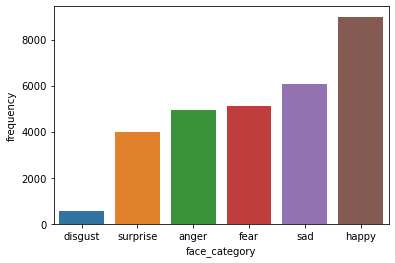

In [2]:
face_categories = ['anger', 'disgust', 'fear', 'happy', 
#'neutral', 
'sad', 'surprise']
n_categories = len(face_categories)
face_categories_mapping = dict(zip(sorted(face_categories),range(8)))
category_frequencies = pd.DataFrame({
    "face_category" : face_categories, 
    "frequency" : [len(os.listdir(f"dataset/{c}")) for c in face_categories]
}).sort_values(by="frequency")
sns.barplot(x="face_category",y="frequency",data=category_frequencies);

In [3]:
n_categories

6

In [4]:
face_categories_mapping

{'anger': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5}

In [5]:
category_frequencies

,face_category,frequency
1,disgust,547
5,surprise,4002
0,anger,4953
2,fear,5121
4,sad,6077
3,happy,8989


# 📐 Rozmiary Obrazków

Ponieważ sieć musi mieć określoną szerokość wejścia wspólną dla wszystkich danych uczących,testowych i klasyfikowanych, należy poznać rozmiary obrazków w zbiorze, aby dobrać odpowiednią wielkość wejścia modelu. Może to trochę potrwać (około 2 minuty).

In [ ]:
# all_image_sizes = []
# for subdirectory in ["train","val","test"]:
#     print(subdirectory)
#     for category in face_categories:
#         print(category)
#         base_path = f"faces/{subdirectory}/{category}"
#         files = os.listdir(base_path)
#         for file in files:
#             path = os.path.join(base_path,file)
#             img = Image.open(path)
#             all_image_sizes.append(img.size)
# # Wygląda na to, że najmniejszy obrazek ma rozmiar 224 x 224 piksele
# sorted(all_image_sizes, key=lambda x:x[0])[0], sorted(all_image_sizes, key=lambda x:x[1])[0]

In [ ]:
# all_image_sizes = []
# for category in face_categories:
#     print(category)
#     base_path = f"dataset/{category}"
#     files = os.listdir(base_path)
#     for file in files:
#         path = os.path.join(base_path,file)
#         img = Image.open(path)
#         all_image_sizes.append(img.size)
# sorted(all_image_sizes, key=lambda x:x[0])[0], sorted(all_image_sizes, key=lambda x:x[1])[0]

# Podział

In [ ]:
# sf.ratio("dataset", output="dataset_splitted", seed=1, ratio=(0.8,0.2), group_prefix=None)

# Wagi

In [6]:
category_frequencies = dict(zip(face_categories,[len(os.listdir(f"dataset_splitted/train/{c}")) for c in face_categories]))

import math
def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    for idx,key in enumerate(keys):
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[idx] = score if score > 1.0 else 1.0
    return class_weight

weights = create_class_weight(category_frequencies,mu=1)
weights

{0: 1.7907493681320699,
 1: 3.995320400294976,
 2: 1.7574874286712223,
 3: 1.194668072288072,
 4: 1.5862541383451105,
 5: 2.004035055420703}

# 📙 Wczytanie i wstępne przetworzenie

In [7]:
base_dir = "C:\\Users\\matlaczj\\Documents\\Projekt_PZ1\\dataset_splitted\\"
train_dir,val_dir,test_dir,train_aug_dir,pred_dir = [pathlib.Path(f"{base_dir}{t}") for t in ["train","val","test","train_aug","pred"]]
train_batch_size = 512
val_test_batch_size = 512
img_height = 48
img_width = 48

# Generowanie

In [ ]:
# # wszystkie transformacje wykonujemy tylko na zbiorze treningowym
# # dogeneruję dane w celu zmniejszenia wariancji modelu
# train_datagen = ImageDataGenerator(
#         #rescale=1./255,
#         rotation_range = 30, 
#         width_shift_range = 0.15, 
#         height_shift_range = 0.15, 
#         shear_range = 0.2, 
#         zoom_range = 0.2, 
#         brightness_range = (0.2,0.8), 
#         horizontal_flip = True
#     )

# for i, one_category in enumerate(os.listdir('dataset_splitted/train')):
#     os.mkdir(f"dataset_splitted/train_aug/{one_category}")
#     train_generator = train_datagen.flow_from_directory(
#             train_dir,
#             #color_mode = "grayscale",
#             target_size=(img_height, img_width),
#             batch_size=train_batch_size,
#             classes = [one_category],
#             save_to_dir = os.path.join("dataset_splitted","train_aug",one_category),
#             class_mode='sparse',
#             shuffle=True)

#     print(one_category)
#     maxindx = len(train_generator)
#     for idx,i in enumerate(range(len(train_generator))):
#         print(f"{idx}/{maxindx}",end=" ")
#         train_generator.next()
#     print("")

In [9]:
train_ds = image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='int',
    color_mode="grayscale",
    batch_size=train_batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=1,
    interpolation='bilinear',
    smart_resize = True
)

# augmented_training_ds = image_dataset_from_directory(
#     directory=train_aug_dir,
#     labels='inferred',
#     label_mode='int',
#     #color_mode="grayscale",
#     batch_size=train_batch_size,
#     image_size=(img_height, img_width),
#     shuffle=True,
#     seed=1,
#     interpolation='bilinear',
#     smart_resize = True
# )

# train_ds = train_ds.concatenate(augmented_training_ds)
train_ds = train_ds.shuffle(seed=1,buffer_size=1000,reshuffle_each_iteration=True)

val_ds = image_dataset_from_directory(
    directory=val_dir,
    labels='inferred',
    label_mode='int',
    color_mode="grayscale",
    batch_size=val_test_batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=1,
    interpolation='bilinear',
    smart_resize = True
)

# test_ds = image_dataset_from_directory(
#     directory=test_dir,
#     labels='inferred',
#     label_mode='int',
#     color_mode="grayscale",
#     batch_size=val_test_batch_size,
#     image_size=(img_height, img_width),
#     shuffle=True,
#     seed=1,
#     interpolation='bilinear',
#     smart_resize = True
# )

Found 23748 files belonging to 6 classes.
Found 5941 files belonging to 6 classes.


# 📺 Oglądanie Obrazków

In [ ]:
rows = 3
cols = 3
if(rows*cols > train_batch_size):
    print("Too many pictures for current batch_size")
else:
    plt.figure(figsize=(15, 15))
    for images, labels in train_ds.take(1):
        for i in range(rows*cols):
            ax = plt.subplot(rows, cols, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(face_categories[labels[i]])
            plt.axis("off")

# 😸 "Buforowanie Wstępne"
zbiorów train/val, by kieszeniować na gpu.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 🔥 Topologia

In [12]:
model = Sequential([
    Conv2D(32, (3,3), input_shape=(48,48,1),padding="same"),
    LeakyReLU(),
    Conv2D(32, (3,3), padding="same"),
    LeakyReLU(),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.2),
    
    Conv2D(64,(3,3),padding="same"),
    LeakyReLU(),
    Conv2D(64,(3,3), padding="same"),
    LeakyReLU(),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    
    Conv2D(128,(3,3),padding="same"),
    LeakyReLU(),
    Conv2D(128,(3,3), padding="same"),
    LeakyReLU(),
    Conv2D(128,(3,3), padding="same"),
    LeakyReLU(),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    
    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    
    Dense(n_categories, activation="softmax")
])

# Podsumowanie

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                      

# Kompilacja

In [14]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=losses.SparseCategoricalCrossentropy(),#from_logits=True
    metrics=['accuracy']
)

# Callbacks

In [15]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        old_lr = self.model.optimizer.lr.read_value()
        new_lr = 0.99 * old_lr
        self.model.optimizer.lr.assign(new_lr)
        old_lr,new_lr = round(float(old_lr),6),round(float(new_lr),6)
        print(f"Reducing LR {old_lr}->{new_lr}")

class ExtendedHistoryCb(tf.keras.callbacks.Callback):
    def on_train_begin(self,logs={}):
        # Zmienne na cały trening używane później do narysowania wykresów.
        # Wyniki r,p dla każdej klasy
        self.val_recalls = []
        self.val_precisions = []
        self.val_f1s = []

        self.avg_val_recall = []
        self.avg_val_precision = []
        self.avg_val_f1 = []
        # Specjalnie dla early stoppingu.
        self.avg_val_f1_history = []

    def on_epoch_end(self,batch,logs={}):
        val_predictions = tf.math.argmax(model.predict(val_ds),axis=1).numpy()
        val_labels = np.concatenate([y for x,y in val_ds],axis=0)

        # Zwracają wyniki dla każdej z klas.
        val_multiclass_recalls = recall_score(val_labels,val_predictions,average=None,zero_division=0)
        val_multiclass_precisions = precision_score(val_labels,val_predictions,average=None,zero_division=0)
        val_multiclass_f1s = f1_score(val_labels,val_predictions,average=None,zero_division=0)
        # Zapisuję te wyniki do zmiennych by zapisać całą historię uczenia.
        self.val_recalls.append(val_multiclass_recalls)
        self.val_precisions.append(val_multiclass_precisions)
        self.val_f1s.append(val_multiclass_f1s)

        self.avg_val_recall = round(mean(val_multiclass_recalls),2)
        self.avg_val_precision = round(mean(val_multiclass_precisions),2)
        self.avg_val_f1 = round(mean(val_multiclass_f1s),2)

        self.avg_val_f1_history.append(self.avg_val_f1)

        tf.print(f"val_recall = {self.avg_val_recall} , val_prec = {self.avg_val_precision} , val_f1 = {self.avg_val_f1}")
                
class EarlyStopByF1(tf.keras.callbacks.Callback):
    def __init__(self, patience = 0):
        super(tf.keras.callbacks.Callback,self).__init__()
        self.patience = patience
    def on_epoch_end(self,epoch,logs={}):
        f1_history = extended_history.avg_val_f1_history
        f1 = extended_history.avg_val_f1
        if(epoch >= self.patience):
            if f1 < min(f1_history[-self.patience:]):
                tf.print(f"Early Stopping: Epoch={epoch},Patience={self.patience}")
                self.model.stop_training = True

# 🚆 Trenowanie

In [16]:
extended_history = ExtendedHistoryCb()

history = model.fit(
    train_ds,
    batch_size=train_batch_size, 
    epochs=100,
    verbose=1,
    callbacks=[
        extended_history,
        EarlyStopByF1(patience=3),
        LearningRateReducerCb()
        ], 
    validation_data=val_ds,
    shuffle=True,
    class_weight = weights
)

Epoch 1/100
47/47 [==============================] - ETA: 0s - loss: 3.5001 - accuracy: 0.2268val_recall = 0.18 , val_prec = 0.2 , val_f1 = 0.09
Reducing LR 0.0001->9.9e-05
47/47 [==============================] - 15s 135ms/step - loss: 3.5001 - accuracy: 0.2268 - val_loss: 1.7345 - val_accuracy: 0.1855
Epoch 2/100
47/47 [==============================] - ETA: 0s - loss: 2.8240 - accuracy: 0.2656val_recall = 0.19 , val_prec = 0.23 , val_f1 = 0.09
Reducing LR 9.9e-05->9.8e-05
47/47 [==============================] - 4s 89ms/step - loss: 2.8240 - accuracy: 0.2656 - val_loss: 1.7716 - val_accuracy: 0.1671
Epoch 3/100
47/47 [==============================] - ETA: 0s - loss: 2.7869 - accuracy: 0.2766val_recall = 0.23 , val_prec = 0.32 , val_f1 = 0.18
Reducing LR 9.8e-05->9.7e-05
47/47 [==============================] - 4s 89ms/step - loss: 2.7869 - accuracy: 0.2766 - val_loss: 1.7160 - val_accuracy: 0.2476
Epoch 4/100
47/47 [==============================] - ETA: 0s - loss: 2.7460 - accurac

In [17]:
model.save("model2")

INFO:tensorflow:Assets written to: model2\assets


In [18]:
model.save_weights("model2_w")

In [19]:
# model.load_weights("model1_w")

# 📊 Wizualizacja Trenowania

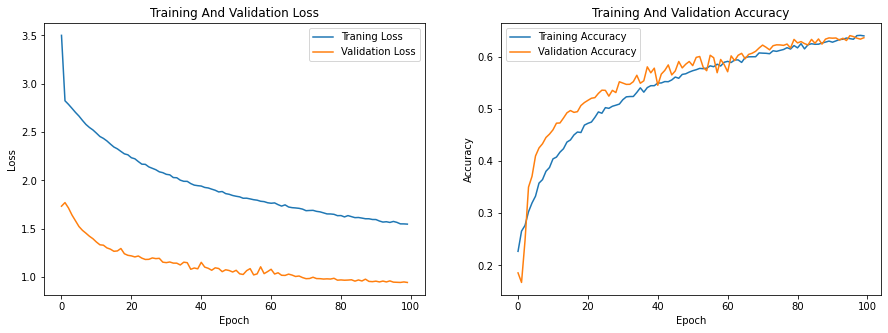

In [20]:
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Training And Validation Loss')
plt.plot(loss,label="Traning Loss")
plt.plot(val_loss,label="Validation Loss")
plt.legend()
plt.subplot(1,2,2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Training And Validation Accuracy')
plt.plot(accuracy,label="Training Accuracy")
plt.plot(val_accuracy,label="Validation Accuracy")
plt.legend()

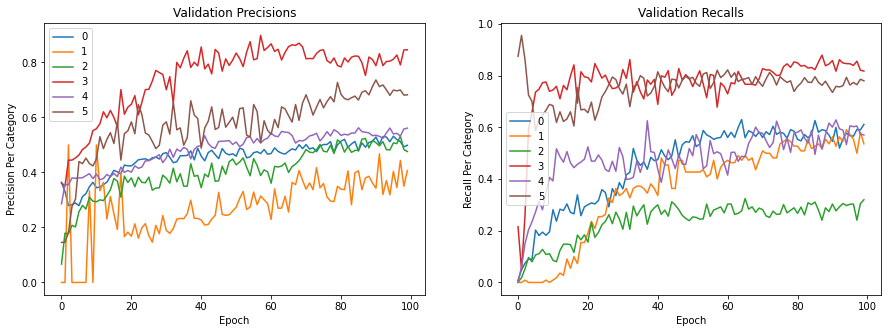

In [23]:
val_recall = extended_history.val_recalls
val_precision = extended_history.val_precisions

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.xlabel("Epoch")
plt.ylabel("Precision Per Category")
plt.title('Validation Precisions')
plt.plot(val_precision,label="Validation Precision")
plt.legend(range(n_categories))
plt.subplot(1,2,2)
plt.xlabel("Epoch")
plt.ylabel("Recall Per Category")
plt.title('Validation Recalls')
plt.plot(val_recall,label="Validation Recall")
plt.legend(range(n_categories))

In [22]:
face_categories_mapping

{'anger': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5}

# ⊹ Confusion Matrix

In [24]:
def plot_confusion_matrix1(ds,n_categories,model,ax):
    """
    Evaluates model's performance on a dataset. Prints confusion
    and returns full report.
    ds - Dataset object with data to predict labels for.
    n_categories - number of possible label outcomes.
    model - model used to predict labels.
    """
    plt.figure(figsize=(15,15))
    y_pred = tf.math.argmax(model.predict(ds),axis=1).numpy()
    y_true = np.concatenate([y for x, y in ds],axis=0)
    confusion = tf.math.confusion_matrix(y_true,y_pred,num_classes=n_categories)
    report = classification_report(y_true,y_pred,zero_division=0)
    
    sns.heatmap(confusion,annot=confusion,ax=ax)
    return report

              precision    recall  f1-score   support

           0       0.61      0.74      0.66      3962
           1       0.65      0.83      0.73       437
           2       0.67      0.45      0.53      4096
           3       0.89      0.87      0.88      7191
           4       0.66      0.67      0.66      4861
           5       0.75      0.87      0.80      3201

    accuracy                           0.73     23748
   macro avg       0.70      0.74      0.71     23748
weighted avg       0.73      0.73      0.73     23748



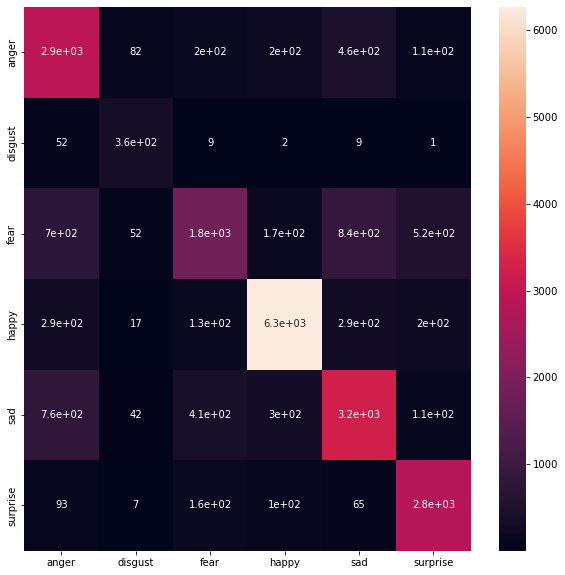

<Figure size 1080x1080 with 0 Axes>

In [25]:
plt.figure(figsize=(10,10))
ax = plt.subplot()
print(plot_confusion_matrix1(train_ds,n_categories,model,ax=ax));
ax.xaxis.set_ticklabels(face_categories);
ax.yaxis.set_ticklabels(face_categories);

              precision    recall  f1-score   support

           0       0.50      0.61      0.55       991
           1       0.41      0.54      0.46       110
           2       0.48      0.32      0.38      1025
           3       0.85      0.82      0.83      1798
           4       0.56      0.57      0.57      1216
           5       0.68      0.78      0.73       801

    accuracy                           0.64      5941
   macro avg       0.58      0.61      0.59      5941
weighted avg       0.64      0.64      0.63      5941



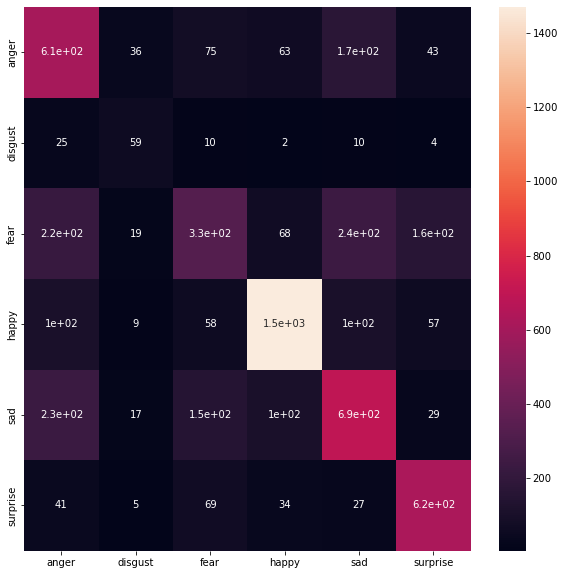

<Figure size 1080x1080 with 0 Axes>

In [26]:
plt.figure(figsize=(10,10))
ax = plt.subplot()
print(plot_confusion_matrix1(val_ds,n_categories,model,ax=ax))
ax.xaxis.set_ticklabels(face_categories);
ax.yaxis.set_ticklabels(face_categories);

In [ ]:
# print(plot_confusion_matrix1(test_ds,n_categories,model))

# **Na wlasnym zbiorku z kamerki z podzialem na klasy**

In [34]:
testowy_wlasny = pathlib.Path("C:\\Users\\matlaczj\\Documents\\Projekt_PZ1\\testowy_wlasny")

own_ds = image_dataset_from_directory(
    directory=testowy_wlasny,
    labels='inferred',
    label_mode='int',
    color_mode="grayscale",
    batch_size=train_batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=1,
    interpolation='bilinear',
    smart_resize = True
)

Found 6 files belonging to 6 classes.


In [ ]:
plt.figure(figsize=(8,5))
ax = plt.subplot()
print(plot_confusion_matrix1(own_ds,n_categories,model,ax=ax));
ax.xaxis.set_ticklabels(face_categories);
ax.yaxis.set_ticklabels(face_categories);